Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6727 - loss: 0.5927 - val_accuracy: 0.6807 - val_loss: 0.5696
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 981ms/step - accuracy: 0.7273 - loss: 0.5597 - val_accuracy: 0.7143 - val_loss: 0.5421
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 993ms/step - accuracy: 0.7318 - loss: 0.5177 - val_accuracy: 0.7227 - val_loss: 0.5164
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7727 - loss: 0.4921 - val_accuracy: 0.7731 - val_loss: 0.4918
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 970ms/step - accuracy: 0.8000 - loss: 0.4752 - val_accuracy: 0.8151 - val_loss: 0.4688


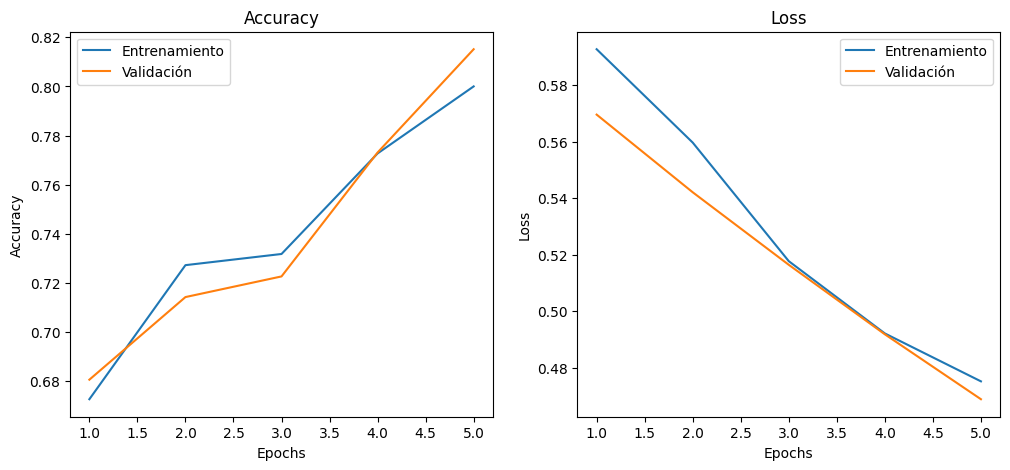

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

ruta_entrenamiento = r"C:\Users\erick\Streaming de Google Drive\Mi unidad\perros y gatos\entreamiento"
ruta_prueba = r"C:\Users\erick\Streaming de Google Drive\Mi unidad\perros y gatos\prueba"

def cargar_rutas_y_etiquetas(ruta):
    imgs = glob.glob(os.path.join(ruta, "*.jpg")) + \
           glob.glob(os.path.join(ruta, "*.jpeg")) + \
           glob.glob(os.path.join(ruta, "*.png"))
    rutas = []
    etiquetas = []
    for x in imgs:
        nombre = os.path.basename(x).lower()
        if "perro" in nombre:
            rutas.append(x)
            etiquetas.append(0)
        elif "gato" in nombre:
            rutas.append(x)
            etiquetas.append(1)
    return rutas, etiquetas

rutas_train, y_train = cargar_rutas_y_etiquetas(ruta_entrenamiento)
rutas_test, y_test = cargar_rutas_y_etiquetas(ruta_prueba)

ds_train = tf.data.Dataset.from_tensor_slices((rutas_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((rutas_test, y_test))

def cargar_imagen(ruta, etiqueta):
    img = tf.io.read_file(ruta)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32)
    return img, etiqueta

ds_train = ds_train.map(cargar_imagen, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(cargar_imagen, num_parallel_calls=tf.data.AUTOTUNE)

ds_train = ds_train.shuffle(500).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(32).prefetch(tf.data.AUTOTUNE)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

hist = model.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test
)


acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Entrenamiento")
plt.plot(epochs, val_acc, label="Validación")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Entrenamiento")
plt.plot(epochs, val_loss, label="Validación")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [5]:
y_true = []
y_pred = []

for imgs, labels in ds_test:
    p = model.predict(imgs)
    y_pred.extend((p > 0.5).astype("int32").flatten())
    y_true.extend(labels.numpy().flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Predicciones:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Etiquetas reales:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


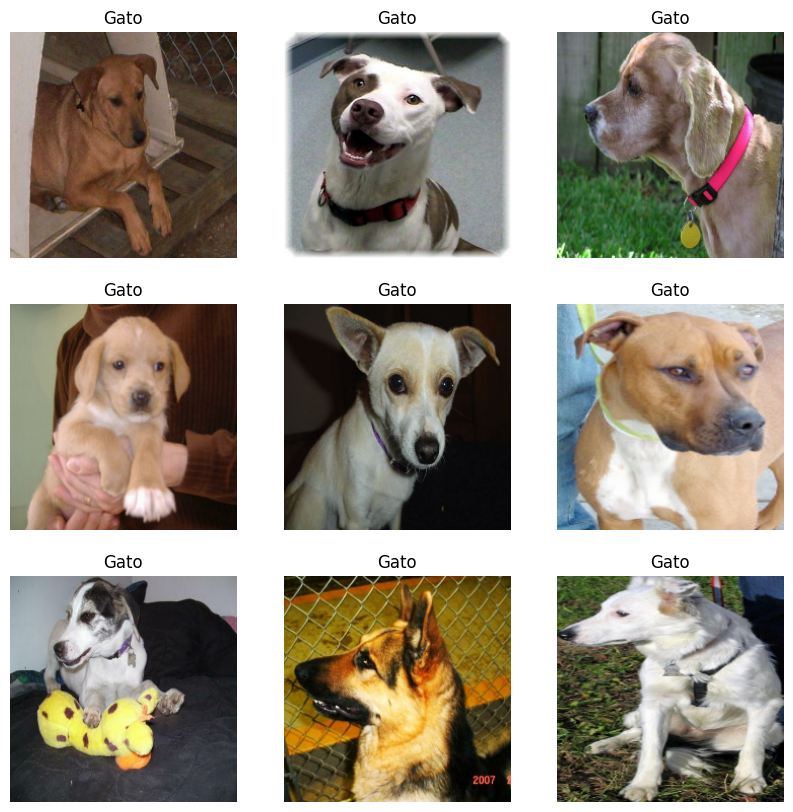

In [7]:
class_names = ["Perro", "Gato"]
image_batch, label_batch = next(iter(ds_test))
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predicciones:\n', predictions.numpy())
print('Etiquetas reales:\n', label_batch.numpy())


plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[int(predictions[i])])
    plt.axis("off")
plt.show()